# Tarea 2 <br/> Clasificación y Búsqueda por Similitud de Sketches Usando Redes Convolucionales <br/> CC6204 Deep Learning, Universidad de Chile 
## Nombres: Felipe Córdova y Miguel Videla
Fecha para completar la tarea: Lunes 30 de Julio de 2018


In [0]:
!pip install --upgrade pip
!pip install -U -q PyDrive
!pip install ndjson

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from matplotlib import pyplot as plt
from skimage.transform import resize
from skimage.draw import line_aa
from google.colab import files
import tensorflow as tf
import numpy as np
import ndjson
import shutil
import time
import os

# Training parameters
epochs = 25
batch_size = 100
learning_rate = 0.001
n_classes = 100
train_data_size = 1000
test_data_size = 50
drive_save_path = 'CC6204/Tarea_2'

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (18.0)


### 0. Google Drive

In [0]:
# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Functions for upload and download files between local host and google drive
def search_folder(folder_name, parent_id):
  """Returns the google drive folder id by name and parents id. If its not founded then creates it."""
  file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % parent_id}).GetList()
  for f in file_list:
    if f['title'] == folder_name and f['mimeType'] == 'application/vnd.google-apps.folder':
      return f['id']
  f = drive.CreateFile({'title': folder_name,
                        'parents':  [{"kind": "drive#fileLink","id": parent_id}],
                        'mimeType': 'application/vnd.google-apps.folder'})
  f.Upload()
  return f.get('id')

def search_folder_by_path(folder_path):
  """Returns the google drive folder id by path."""
  parent_id = 'root'
  folders = folder_path.split('/')
  for folder_name in folders:
    parent_id = search_folder(folder_name, parent_id)
  return parent_id

def upload_files_to_drive(local_folder_path, drive_folder_path):
  """Uploads files from a local folder to drive."""
  drive_folder_id = search_folder_by_path(drive_folder_path)
  file_names = os.listdir(local_folder_path)
  for file_name in file_names:
    drive_file = drive.CreateFile({'title': file_name,
                                   'parents':  [{"kind": "drive#fileLink","id": drive_folder_id}]})
    drive_file.SetContentFile(local_folder_path + '/' + file_name)
    drive_file.Upload()
  print('Files uploaded sucessfully to drive!')
  
def download_files_from_drive(local_folder_path, drive_folder_path):
  """Downloads files from drive to local host."""
  drive_folder_id = search_folder_by_path(drive_folder_path)
  file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % drive_folder_id}).GetList()
  for file in file_list:
    drive_file = drive.CreateFile({'id': file['id']})
    drive_file.GetContentFile(local_folder_path + '/' + file['title'])
  print('Files downloaded sucessfully from drive!')

### 1. Extracción de Datos

In [0]:
os.makedirs('./CC6204/Tarea_2/quickdraw_dataset')
!gsutil -m cp -r gs://quickdraw_dataset/full/simplified ./CC6204/Tarea_2/quickdraw_dataset

Copying gs://quickdraw_dataset/full/simplified/The Eiffel Tower.ndjson...
Copying gs://quickdraw_dataset/full/simplified/The Great Wall of China.ndjson...
Copying gs://quickdraw_dataset/full/simplified/The Mona Lisa.ndjson...
Copying gs://quickdraw_dataset/full/simplified/aircraft carrier.ndjson...
Copying gs://quickdraw_dataset/full/simplified/airplane.ndjson...
Copying gs://quickdraw_dataset/full/simplified/alarm clock.ndjson...
Copying gs://quickdraw_dataset/full/simplified/ambulance.ndjson...
Copying gs://quickdraw_dataset/full/simplified/angel.ndjson...
Copying gs://quickdraw_dataset/full/simplified/animal migration.ndjson...
Copying gs://quickdraw_dataset/full/simplified/ant.ndjson...
Copying gs://quickdraw_dataset/full/simplified/anvil.ndjson...
Copying gs://quickdraw_dataset/full/simplified/apple.ndjson...
Copying gs://quickdraw_dataset/full/simplified/arm.ndjson...
Copying gs://quickdraw_dataset/full/simplified/asparagus.ndjson...
Copying gs://quickdraw_dataset/full/simplified

Copying gs://quickdraw_dataset/full/simplified/bird.ndjson...
Copying gs://quickdraw_dataset/full/simplified/birthday cake.ndjson...
Copying gs://quickdraw_dataset/full/simplified/blackberry.ndjson...
Copying gs://quickdraw_dataset/full/simplified/blueberry.ndjson...
Copying gs://quickdraw_dataset/full/simplified/boomerang.ndjson...
Copying gs://quickdraw_dataset/full/simplified/book.ndjson...
Copying gs://quickdraw_dataset/full/simplified/bottlecap.ndjson...
Copying gs://quickdraw_dataset/full/simplified/bowtie.ndjson...
Copying gs://quickdraw_dataset/full/simplified/bracelet.ndjson...
Copying gs://quickdraw_dataset/full/simplified/brain.ndjson...
Copying gs://quickdraw_dataset/full/simplified/bread.ndjson...
Copying gs://quickdraw_dataset/full/simplified/bridge.ndjson...
Copying gs://quickdraw_dataset/full/simplified/broccoli.ndjson...
Copying gs://quickdraw_dataset/full/simplified/broom.ndjson...
Copying gs://quickdraw_dataset/full/simplified/bucket.ndjson...
Copying gs://quickdraw_

Copying gs://quickdraw_dataset/full/simplified/cello.ndjson...
Copying gs://quickdraw_dataset/full/simplified/chair.ndjson...
Copying gs://quickdraw_dataset/full/simplified/chandelier.ndjson...
Copying gs://quickdraw_dataset/full/simplified/church.ndjson...
Copying gs://quickdraw_dataset/full/simplified/circle.ndjson...
Copying gs://quickdraw_dataset/full/simplified/clarinet.ndjson...
Copying gs://quickdraw_dataset/full/simplified/clock.ndjson...
Copying gs://quickdraw_dataset/full/simplified/cloud.ndjson...
Copying gs://quickdraw_dataset/full/simplified/coffee cup.ndjson...
Copying gs://quickdraw_dataset/full/simplified/compass.ndjson...
Copying gs://quickdraw_dataset/full/simplified/computer.ndjson...
Copying gs://quickdraw_dataset/full/simplified/cookie.ndjson...
Copying gs://quickdraw_dataset/full/simplified/cooler.ndjson...
Copying gs://quickdraw_dataset/full/simplified/couch.ndjson...
Copying gs://quickdraw_dataset/full/simplified/cow.ndjson...
Copying gs://quickdraw_dataset/full

Copying gs://quickdraw_dataset/full/simplified/ear.ndjson...
Copying gs://quickdraw_dataset/full/simplified/elbow.ndjson...
Copying gs://quickdraw_dataset/full/simplified/elephant.ndjson...
Copying gs://quickdraw_dataset/full/simplified/envelope.ndjson...
Copying gs://quickdraw_dataset/full/simplified/eraser.ndjson...
Copying gs://quickdraw_dataset/full/simplified/eye.ndjson...
Copying gs://quickdraw_dataset/full/simplified/eyeglasses.ndjson...
Copying gs://quickdraw_dataset/full/simplified/face.ndjson...
Copying gs://quickdraw_dataset/full/simplified/fan.ndjson...
Copying gs://quickdraw_dataset/full/simplified/feather.ndjson...
Copying gs://quickdraw_dataset/full/simplified/fence.ndjson...
Copying gs://quickdraw_dataset/full/simplified/finger.ndjson...
Copying gs://quickdraw_dataset/full/simplified/fire hydrant.ndjson...
Copying gs://quickdraw_dataset/full/simplified/fireplace.ndjson...
Copying gs://quickdraw_dataset/full/simplified/firetruck.ndjson...
Copying gs://quickdraw_dataset/f

Copying gs://quickdraw_dataset/full/simplified/hand.ndjson...
Copying gs://quickdraw_dataset/full/simplified/harp.ndjson...
Copying gs://quickdraw_dataset/full/simplified/hat.ndjson...
Copying gs://quickdraw_dataset/full/simplified/headphones.ndjson...
Copying gs://quickdraw_dataset/full/simplified/hedgehog.ndjson...
Copying gs://quickdraw_dataset/full/simplified/helicopter.ndjson...
Copying gs://quickdraw_dataset/full/simplified/helmet.ndjson...
Copying gs://quickdraw_dataset/full/simplified/hexagon.ndjson...
Copying gs://quickdraw_dataset/full/simplified/hockey puck.ndjson...
Copying gs://quickdraw_dataset/full/simplified/hockey stick.ndjson...
Copying gs://quickdraw_dataset/full/simplified/horse.ndjson...
Copying gs://quickdraw_dataset/full/simplified/hospital.ndjson...
Copying gs://quickdraw_dataset/full/simplified/hot air balloon.ndjson...
Copying gs://quickdraw_dataset/full/simplified/hot dog.ndjson...
Copying gs://quickdraw_dataset/full/simplified/hot tub.ndjson...
Copying gs://

Copying gs://quickdraw_dataset/full/simplified/lion.ndjson...
Copying gs://quickdraw_dataset/full/simplified/lipstick.ndjson...
Copying gs://quickdraw_dataset/full/simplified/lobster.ndjson...
Copying gs://quickdraw_dataset/full/simplified/lollipop.ndjson...
Copying gs://quickdraw_dataset/full/simplified/mailbox.ndjson...
Copying gs://quickdraw_dataset/full/simplified/map.ndjson...
Copying gs://quickdraw_dataset/full/simplified/marker.ndjson...
Copying gs://quickdraw_dataset/full/simplified/matches.ndjson...
Copying gs://quickdraw_dataset/full/simplified/megaphone.ndjson...
Copying gs://quickdraw_dataset/full/simplified/mermaid.ndjson...
Copying gs://quickdraw_dataset/full/simplified/microphone.ndjson...
Copying gs://quickdraw_dataset/full/simplified/microwave.ndjson...
Copying gs://quickdraw_dataset/full/simplified/monkey.ndjson...
Copying gs://quickdraw_dataset/full/simplified/moon.ndjson...
Copying gs://quickdraw_dataset/full/simplified/mosquito.ndjson...
Copying gs://quickdraw_data

Copying gs://quickdraw_dataset/full/simplified/pants.ndjson...
Copying gs://quickdraw_dataset/full/simplified/paper clip.ndjson...
Copying gs://quickdraw_dataset/full/simplified/parachute.ndjson...
Copying gs://quickdraw_dataset/full/simplified/parrot.ndjson...
Copying gs://quickdraw_dataset/full/simplified/passport.ndjson...
Copying gs://quickdraw_dataset/full/simplified/peanut.ndjson...
Copying gs://quickdraw_dataset/full/simplified/pear.ndjson...
Copying gs://quickdraw_dataset/full/simplified/peas.ndjson...
Copying gs://quickdraw_dataset/full/simplified/pencil.ndjson...
Copying gs://quickdraw_dataset/full/simplified/penguin.ndjson...
Copying gs://quickdraw_dataset/full/simplified/piano.ndjson...
Copying gs://quickdraw_dataset/full/simplified/pickup truck.ndjson...
Copying gs://quickdraw_dataset/full/simplified/picture frame.ndjson...
Copying gs://quickdraw_dataset/full/simplified/pig.ndjson...
Copying gs://quickdraw_dataset/full/simplified/pillow.ndjson...
Copying gs://quickdraw_dat

Copying gs://quickdraw_dataset/full/simplified/river.ndjson...
Copying gs://quickdraw_dataset/full/simplified/roller coaster.ndjson...
Copying gs://quickdraw_dataset/full/simplified/rollerskates.ndjson...
Copying gs://quickdraw_dataset/full/simplified/sailboat.ndjson...
Copying gs://quickdraw_dataset/full/simplified/sandwich.ndjson...
Copying gs://quickdraw_dataset/full/simplified/saw.ndjson...
Copying gs://quickdraw_dataset/full/simplified/saxophone.ndjson...
Copying gs://quickdraw_dataset/full/simplified/school bus.ndjson...
Copying gs://quickdraw_dataset/full/simplified/scissors.ndjson...
Copying gs://quickdraw_dataset/full/simplified/scorpion.ndjson...
Copying gs://quickdraw_dataset/full/simplified/screwdriver.ndjson...
Copying gs://quickdraw_dataset/full/simplified/sea turtle.ndjson...
Copying gs://quickdraw_dataset/full/simplified/see saw.ndjson...
Copying gs://quickdraw_dataset/full/simplified/shark.ndjson...
Copying gs://quickdraw_dataset/full/simplified/sheep.ndjson...
Copying

Copying gs://quickdraw_dataset/full/simplified/squiggle.ndjson...
Copying gs://quickdraw_dataset/full/simplified/squirrel.ndjson...
Copying gs://quickdraw_dataset/full/simplified/stairs.ndjson...
Copying gs://quickdraw_dataset/full/simplified/star.ndjson...
Copying gs://quickdraw_dataset/full/simplified/steak.ndjson...
Copying gs://quickdraw_dataset/full/simplified/stereo.ndjson...
Copying gs://quickdraw_dataset/full/simplified/stethoscope.ndjson...
Copying gs://quickdraw_dataset/full/simplified/stitches.ndjson...
Copying gs://quickdraw_dataset/full/simplified/stop sign.ndjson...
Copying gs://quickdraw_dataset/full/simplified/stove.ndjson...
Copying gs://quickdraw_dataset/full/simplified/strawberry.ndjson...
Copying gs://quickdraw_dataset/full/simplified/streetlight.ndjson...
Copying gs://quickdraw_dataset/full/simplified/string bean.ndjson...
Copying gs://quickdraw_dataset/full/simplified/submarine.ndjson...
Copying gs://quickdraw_dataset/full/simplified/suitcase.ndjson...
Copying gs:

Copying gs://quickdraw_dataset/full/simplified/tractor.ndjson...
Copying gs://quickdraw_dataset/full/simplified/traffic light.ndjson...
Copying gs://quickdraw_dataset/full/simplified/train.ndjson...
Copying gs://quickdraw_dataset/full/simplified/tree.ndjson...
Copying gs://quickdraw_dataset/full/simplified/triangle.ndjson...
Copying gs://quickdraw_dataset/full/simplified/trombone.ndjson...
Copying gs://quickdraw_dataset/full/simplified/truck.ndjson...
Copying gs://quickdraw_dataset/full/simplified/trumpet.ndjson...
Copying gs://quickdraw_dataset/full/simplified/umbrella.ndjson...
Copying gs://quickdraw_dataset/full/simplified/underwear.ndjson...
Copying gs://quickdraw_dataset/full/simplified/van.ndjson...
Copying gs://quickdraw_dataset/full/simplified/vase.ndjson...
Copying gs://quickdraw_dataset/full/simplified/violin.ndjson...
Copying gs://quickdraw_dataset/full/simplified/washing machine.ndjson...
Copying gs://quickdraw_dataset/full/simplified/watermelon.ndjson...
Copying gs://quick

### 2. Pre-procesamiento de Datos

In [0]:
def drawing_to_np(drawing):
  """Sketch drawing to 256x256 numpy array conversion."""
  sketch = np.zeros((256, 256), dtype=np.uint8)
  for line_y, line_x in drawing:  
    for i in range(len(line_x) - 1):
      rr, cc, val = line_aa(line_x[i], line_y[i], line_x[i+1], line_y[i+1])
      sketch[rr, cc] = val * 255
  return sketch
 
def _int64_feature(value):
  """Int64 train feature conversion."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
  """Bytes train feautre conversion."""
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def img_to_tfrecords(img, label, output_file):
  """Numpy img to tfrecords file."""
  img_raw = img.tostring()
  height = img.shape[0]
  width = img.shape[1]
  feature = { 'img_raw': _bytes_feature(img_raw),
              'height': _int64_feature(height),
              'width': _int64_feature(width),
              'label': _int64_feature(label) }
  example = tf.train.Example(features=tf.train.Features(feature=feature))
  serialized = example.SerializeToString()
  writer = tf.python_io.TFRecordWriter(output_file)
  writer.write(serialized)
  writer.close()
  

# Filepaths definition
classes = os.listdir('./CC6204/Tarea_2/quickdraw_dataset/simplified')
classes.sort()
classes = np.roll(classes, -3)
tfrecords_path = './CC6204/Tarea_2/quickdraw_dataset/tfrecords'
os.makedirs(tfrecords_path + '/train') 
os.makedirs(tfrecords_path + '/test') 

# Data preprocessing
print('Start data preprocessing...')
for i in range(n_classes):
  with open('./CC6204/Tarea_2/quickdraw_dataset/simplified/' + classes[i]) as f:
    ndjson_file = ndjson.load(f)
    for sample in range(train_data_size + test_data_size):
      word = ndjson_file[sample]["word"]
      drawing = ndjson_file[sample]["drawing"]
      # Sketch drawing and resizing
      sketch = drawing_to_np(drawing)
      sketch = resize(sketch, (128, 128))
      # TFRecords file conversion
      if sample < train_data_size:
        img_to_tfrecords(sketch, i, tfrecords_path+'/train/'+word+'_'+str(sample)+'.tfrecords')
      else:
        img_to_tfrecords(sketch, i, tfrecords_path+'/test/'+word+'_'+str(sample)+'.tfrecords')
    print('Class: ' + str(i) +' - '+ word)
  # Borrar archivo ndjson correspondiente
  #os.remove('./CC6204/Tarea_2/quickdraw_dataset/simplified/' + classes[i])
# Borrar resto de archivos no utilizados
shutil.rmtree('./CC6204/Tarea_2/quickdraw_dataset/simplified')
print('Data preprocessing finished succesfully!')

Start data preprocessing...


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Class: 0 - aircraft carrier
Class: 1 - airplane
Class: 2 - alarm clock
Class: 3 - ambulance
Class: 4 - angel
Class: 5 - animal migration
Class: 6 - ant
Class: 7 - anvil
Class: 8 - apple
Class: 9 - arm
Class: 10 - asparagus
Class: 11 - axe
Class: 12 - backpack
Class: 13 - banana
Class: 14 - bandage
Class: 15 - barn
Class: 16 - baseball bat
Class: 17 - baseball
Class: 18 - basket
Class: 19 - basketball
Class: 20 - bat
Class: 21 - bathtub
Class: 22 - beach
Class: 23 - bear
Class: 24 - beard
Class: 25 - bed
Class: 26 - bee
Class: 27 - belt
Class: 28 - bench
Class: 29 - bicycle
Class: 30 - binoculars
Class: 31 - bird
Class: 32 - birthday cake
Class: 33 - blackberry
Class: 34 - blueberry
Class: 35 - book
Class: 36 - boomerang
Class: 37 - bottlecap
Class: 38 - bowtie
Class: 39 - bracelet
Class: 40 - brain
Class: 41 - bread
Class: 42 - bridge
Class: 43 - broccoli
Class: 44 - broom
Class: 45 - bucket
Class: 46 - bulldozer
Class: 47 - bus
Class: 48 - bush
Class: 49 - butterfly
Class: 50 - cactus

Data preprocessing finished succesfully!


### 3. Conjunto de Datos

#### 3.1. Construcción

In [0]:
def _parse_function(example_proto):
  """Parse a tfrecord file into tensors."""
  features = { 'img_raw': tf.FixedLenFeature([], tf.string),
               'height': tf.FixedLenFeature([], tf.int64),
               'width': tf.FixedLenFeature([], tf.int64),
               'label': tf.FixedLenFeature([], tf.int64) }
  parsed_features = tf.parse_single_example(example_proto, features)
  height = parsed_features["height"]
  width = parsed_features["width"]
  label = parsed_features["label"]
  img = tf.decode_raw(parsed_features["img_raw"], tf.float64)
  img = tf.reshape(img, [128, 128, 1])
  img = tf.cast(img, tf.float32)
  return img, label


with tf.name_scope('Dataset') as scope:
  # Filename placeholder
  filenames = tf.placeholder(tf.string, shape=[None])
  # TFRecordDataset construction
  dataset = tf.data.TFRecordDataset(filenames)
  # Parse the tfrecord files into tensors
  dataset = dataset.map(_parse_function)
  # Dataset batching
  dataset = dataset.batch(batch_size)
  # Dataset iterator
  iterator = dataset.make_initializable_iterator()
  # Dataset batch extraction [batch_data, batch_label]
  next_element = iterator.get_next()

# Filenames of tfrecords files
training_filenames = os.listdir('./CC6204/Tarea_2/quickdraw_dataset/tfrecords/train')
testing_filenames = os.listdir('./CC6204/Tarea_2/quickdraw_dataset/tfrecords/test')

# Filepaths of tfrecors files
training_filenames = list(map(lambda filename: './CC6204/Tarea_2/quickdraw_dataset/tfrecords/train/'+filename, training_filenames))
testing_filenames = list(map(lambda filename: './CC6204/Tarea_2/quickdraw_dataset/tfrecords/test/'+filename, testing_filenames))

#### 3.2. Exploración

Data Batch Shape: (100, 128, 128, 1) | Data Batch Type: float32
Label Batch Shape: (100,) | Label Batch Type: int64


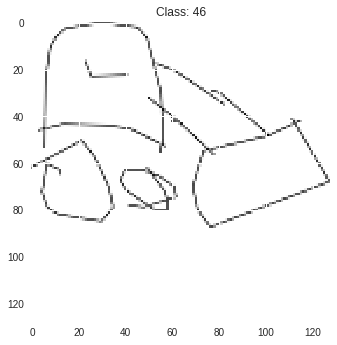

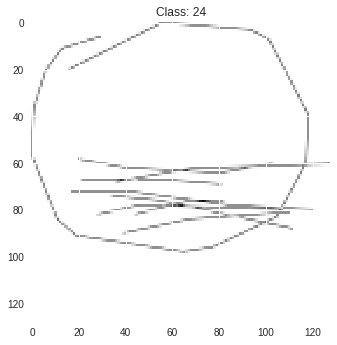

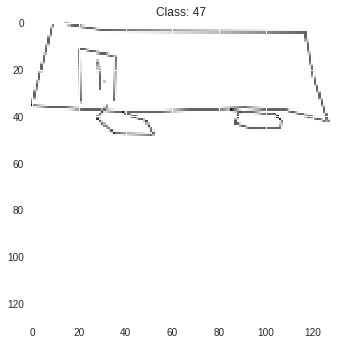

In [0]:
# Dataset exploration
n_samples = 3
with tf.Session() as sess:
  sess.run(iterator.initializer, feed_dict={filenames: training_filenames})
  data_batch, label_batch = sess.run(iterator.get_next())
  print('Data Batch Shape: ' + str(data_batch.shape) + ' | Data Batch Type: ' + str(data_batch.dtype))
  print('Label Batch Shape: ' + str(label_batch.shape) + ' | Label Batch Type: ' + str(label_batch.dtype))
  for _ in range(n_samples): 
    sample = np.random.randint(batch_size)
    img_sample = data_batch[sample]
    img_sample = np.squeeze(img_sample, axis=(2,))
    label_sample = label_batch[sample]
    plt.imshow(img_sample)
    plt.title('Class: ' + str(label_sample))
    plt.show()
  sess.close()

### 4. Definición de Modelos

In [0]:
def skNet(input_data):
  """Model function for skNet."""
  with tf.name_scope('skNet'):    
    # Convolutional Layer 1.1
    with tf.name_scope('conv1_1'):
      bn1_1 = tf.layers.batch_normalization(input_data)
      conv1_1 = tf.layers.conv2d(
          inputs=bn1_1,
          filters=64,
          kernel_size=[3, 3],
          padding='same')
      act1_1 = tf.nn.relu(conv1_1)
    
    # Convolutional Layer 1.2
    with tf.name_scope('conv1_2'):
      bn1_2 = tf.layers.batch_normalization(act1_1)
      conv1_2 = tf.layers.conv2d(
          inputs=bn1_2,
          filters=64,
          kernel_size=[3, 3],
          padding='same')
      act1_2 = tf.nn.relu(conv1_2)
      
    # Pooling Layer 1
    with tf.name_scope('maxpool_1'):
      maxpool_1 = tf.layers.max_pooling2d(
          inputs=act1_2, 
          pool_size=[3, 3], 
          strides=2)
      
     # Convolutional Layer 2.1
    with tf.name_scope('conv2_1'):
      bn2_1 = tf.layers.batch_normalization(maxpool_1)
      conv2_1 = tf.layers.conv2d(
          inputs=bn2_1,
          filters=64,
          kernel_size=[3, 3],
          padding='same')
      act2_1 = tf.nn.relu(conv2_1)
    
    # Convolutional Layer 2.2
    with tf.name_scope('conv2_2'):
      bn2_2 = tf.layers.batch_normalization(act2_1)
      conv2_2 = tf.layers.conv2d(
          inputs=bn2_2,
          filters=64,
          kernel_size=[3, 3],
          padding='same')
      act2_2 = tf.nn.relu(conv2_2)
      
    # Pooling Layer 2
    with tf.name_scope('maxpool_2'):
      maxpool_2 = tf.layers.max_pooling2d(
          inputs=act2_2, 
          pool_size=[3, 3], 
          strides=2)
    
    # Convolutional Layer 3.1
    with tf.name_scope('conv3_1'):
      bn3_1 = tf.layers.batch_normalization(maxpool_2)
      conv3_1 = tf.layers.conv2d(
          inputs=bn3_1,
          filters=64,
          kernel_size=[3, 3],
          padding='same')
      act3_1 = tf.nn.relu(conv3_1)
    
    # Convolutional Layer 3.2
    with tf.name_scope('conv3_2'):
      bn3_2 = tf.layers.batch_normalization(act3_1)
      conv3_2 = tf.layers.conv2d(
          inputs=bn3_2,
          filters=64,
          kernel_size=[3, 3],
          padding='same')
      act3_2 = tf.nn.relu(conv3_2)
      
    # Pooling Layer 3
    with tf.name_scope('maxpool_3'):
      maxpool_3 = tf.layers.max_pooling2d(
          inputs=act3_2, 
          pool_size=[3, 3], 
          strides=2)
      
    # Convolutional Layer 4.1
    with tf.name_scope('conv4_1'):
      bn4_1 = tf.layers.batch_normalization(maxpool_3)
      conv4_1 = tf.layers.conv2d(
          inputs=bn4_1,
          filters=64,
          kernel_size=[3, 3],
          padding='same')
      act4_1 = tf.nn.relu(conv4_1)
    
    # Convolutional Layer 4.2
    with tf.name_scope('conv4_2'):
      bn4_2 = tf.layers.batch_normalization(act4_1)
      conv4_2 = tf.layers.conv2d(
          inputs=bn4_2,
          filters=64,
          kernel_size=[3, 3],
          padding='same')
      act4_2 = tf.nn.relu(conv4_2)
      
    # Pooling Layer 4
    with tf.name_scope('maxpool_4'):
      maxpool_4 = tf.layers.max_pooling2d(
          inputs=act4_2, 
          pool_size=[3, 3], 
          strides=2)

    # Fully-connected Layer 1
    with tf.name_scope('fc1'):
      pool4_flat = tf.layers.flatten(maxpool_4)
      fc1 = tf.layers.dense(
          inputs=pool4_flat,
          units=1024)
      act_fc1 = tf.nn.relu(fc1)

    # Fully-connected Layer 2
    with tf.name_scope('fc2'):
      fc2 = tf.layers.dense(
          inputs=act_fc1,
          units=100)

      return fc2

  
def skResNet(input_data):
  """Model function for skResNet."""
  with tf.name_scope('skResNet'):
    # Convolutional Layer 1.1
    with tf.name_scope('conv1_1'):
      bn1_1 = tf.layers.batch_normalization(input_data)
      conv1_1 = tf.layers.conv2d(
          inputs=bn1_1,
          filters=64,
          kernel_size=[3, 3],
          padding="same")
      act1_1 = tf.nn.relu(conv1_1)

    # Convolutional Layer 1.2
    with tf.name_scope('conv1_2'):
      bn1_2 = tf.layers.batch_normalization(act1_1)
      conv1_2 = tf.layers.conv2d(
          inputs=bn1_2,
          filters=64,
          kernel_size=[3, 3],
          padding="same")
      act1_2 = tf.nn.relu(conv1_2)

    # Pooling Layer 1
    with tf.name_scope('maxpool_1'):
      maxpool_1 = tf.layers.max_pooling2d(
          inputs=act1_2, 
          pool_size=[3, 3], 
          strides=2)
      
    # Convolutional Layer 2.1
    with tf.name_scope('conv2_1'):
      bn2_1 = tf.layers.batch_normalization(maxpool_1)
      conv2_1 = tf.layers.conv2d(
          inputs=bn2_1,
          filters=64,
          kernel_size=[3, 3],
          padding="same")
      act2_1 = tf.nn.relu(conv2_1)

    # Convolutional Layer 2.2
    with tf.name_scope('conv2_2'):
      bn2_2 = tf.layers.batch_normalization(act2_1)
      conv2_2 = tf.layers.conv2d(
          inputs=bn2_2,
          filters=64,
          kernel_size=[3, 3],
          padding="same")
      act2_2 = tf.nn.relu(conv2_2)

    # Residual Convolutional Layer 1
    with tf.name_scope('residual_1'):
      residual_1 = tf.add(act2_2, maxpool_1)

    # Convolutional Layer 3.1
    with tf.name_scope('conv3_1'):
      bn3_1 = tf.layers.batch_normalization(residual_1)
      conv3_1 = tf.layers.conv2d(
          inputs=bn3_1,
          filters=64,
          kernel_size=[3, 3],
          padding="same")
      act3_1 = tf.nn.relu(conv3_1)

    # Convolutional Layer 3.2
    with tf.name_scope('conv3_2'):
      bn3_2 = tf.layers.batch_normalization(act3_1)
      conv3_2 = tf.layers.conv2d(
          inputs=bn3_2,
          filters=64,
          kernel_size=[3, 3],
          padding="same")
      act3_2 = tf.nn.relu(conv3_2)

    # Residual Convolutional Layer 2
    with tf.name_scope('residual_2'):
      residual_2 = tf.add(act3_2, residual_1)

    # Convolutional Layer 4.1
    with tf.name_scope('conv4_1'):
      bn4_1 = tf.layers.batch_normalization(residual_2)
      conv4_1 = tf.layers.conv2d(
          inputs=bn4_1,
          filters=128,
          kernel_size=[3, 3],
          padding="same")
      act4_1 = tf.nn.relu(conv4_1)

    # Pooling Layer 2
    with tf.name_scope('maxpool_2'):
      maxpool_2 = tf.layers.max_pooling2d(
          inputs=act4_1, 
          pool_size=[3, 3], 
          strides=2)

    # Convolutional Layer 5.1
    with tf.name_scope('conv5_1'):
      bn5_1 = tf.layers.batch_normalization(maxpool_2)
      conv5_1 = tf.layers.conv2d(
          inputs=bn5_1,
          filters=128,
          kernel_size=[3, 3],
          padding="same")
      act5_1 = tf.nn.relu(conv5_1)

    # Convolutional Layer 5.2
    with tf.name_scope('conv5_2'):
      bn5_2 = tf.layers.batch_normalization(act5_1)
      conv5_2 = tf.layers.conv2d(
          inputs=bn5_2,
          filters=128,
          kernel_size=[3, 3],
          padding="same")
      act5_2 = tf.nn.relu(conv5_2)

    # Residual Convolutional Layer 3
    with tf.name_scope('residual_3'):
      residual_3 = tf.add(act5_2, maxpool_2)

    # Convolutional Layer 6.1
    with tf.name_scope('conv6_1'):
      bn6_1 = tf.layers.batch_normalization(residual_3)
      conv6_1 = tf.layers.conv2d(
          inputs=bn6_1,
          filters=128,
          kernel_size=[3, 3],
          padding="same")
      act6_1 = tf.nn.relu(conv6_1)

    # Convolutional Layer 6.2
    with tf.name_scope('conv6_2'):
      bn6_2 = tf.layers.batch_normalization(act6_1)
      conv6_2 = tf.layers.conv2d(
          inputs=bn6_2,
          filters=128,
          kernel_size=[3, 3],
          padding="same")
      act6_2 = tf.nn.relu(conv6_2)

    # Residual Convolutional Layer 4
    with tf.name_scope('residual_4'):
      residual_4 = tf.add(act6_2, residual_3)

    # Convolutional Layer 7.1
    with tf.name_scope('conv7_1'):
      bn7_1 = tf.layers.batch_normalization(residual_4)
      conv7_1 = tf.layers.conv2d(
          inputs=bn7_1,
          filters=256,
          kernel_size=[3, 3],
          padding="same")
      act7_1 = tf.nn.relu(conv7_1)

    # Pooling Layer 3
    with tf.name_scope('maxpool_3'):
      maxpool_3 = tf.layers.max_pooling2d(
          inputs=act7_1, 
          pool_size=[3, 3], 
          strides=2)

    # Convolutional Layer 8.1
    with tf.name_scope('conv8_1'):
      bn8_1 = tf.layers.batch_normalization(maxpool_3)
      conv8_1 = tf.layers.conv2d(
          inputs=bn8_1,
          filters=256,
          kernel_size=[3, 3],
          padding="same")
      act8_1 = tf.nn.relu(conv8_1)

    # Convolutional Layer 8.2
    with tf.name_scope('conv8_2'):
      bn8_2 = tf.layers.batch_normalization(act8_1)
      conv8_2 = tf.layers.conv2d(
          inputs=bn8_2,
          filters=256,
          kernel_size=[3, 3],
          padding="same")
      act8_2 = tf.nn.relu(conv8_2)

    # Residual Convolutional Layer 5
    with tf.name_scope('residual_5'):
      residual_5 = tf.add(act8_2, maxpool_3)

    # Convolutional Layer 9.1
    with tf.name_scope('conv9_1'):
      bn9_1 = tf.layers.batch_normalization(residual_5)
      conv9_1 = tf.layers.conv2d(
          inputs=bn9_1,
          filters=256,
          kernel_size=[3, 3],
          padding="same")
      act9_1 = tf.nn.relu(conv9_1)

    # Convolutional Layer 9.2
    with tf.name_scope('conv9_2'):
      bn9_2 = tf.layers.batch_normalization(act9_1)
      conv9_2 = tf.layers.conv2d(
          inputs=bn9_2,
          filters=256,
          kernel_size=[3, 3],
          padding="same")
      act9_2 = tf.nn.relu(conv9_2)

    # Residual Convolutional Layer 6
    with tf.name_scope('residual_6'):
      residual_6 = tf.add(act9_2, residual_5)

    # Convolutional Layer 10.1
    with tf.name_scope('conv10_1'):
      bn10_1 = tf.layers.batch_normalization(residual_6)
      conv10_1 = tf.layers.conv2d(
          inputs=bn10_1,
          filters=256,
          kernel_size=[3, 3],
          padding="same")
      act10_1 = tf.nn.relu(conv10_1)

    # Pooling Layer 4
    with tf.name_scope('maxpool_4'):
      maxpool_4 = tf.layers.max_pooling2d(
          inputs=act10_1, 
          pool_size=[3, 3], 
          strides=2)

    # Fully-connected Layer 1
    with tf.name_scope('fc1'):
      pool4_flat = tf.layers.flatten(maxpool_4)
      fc1 = tf.layers.dense(
          inputs=pool4_flat,
          units=1024)
      act_fc1 = tf.nn.relu(fc1) 

    # Fully-connected Layer 2
    with tf.name_scope('fc2'):
      fc2 = tf.layers.dense(
          inputs=act_fc1,
          units=100)
  
      return fc2

### 5. Entrenamiento de Modelos

**-Observación:** Saltar sección si los modelos ya se encuentran en Google Drive.



#### 5.1. skNet

In [0]:
# Default graph reset
tf.reset_default_graph()

# Dataset
with tf.name_scope('Dataset') as scope:
  # Filename placeholder
  filenames = tf.placeholder(tf.string, shape=[None])
  # TFRecordDataset construction
  dataset = tf.data.TFRecordDataset(filenames)
  # Parse the tfrecord files into tensors
  dataset = dataset.map(_parse_function)
  # Dataset batching
  dataset = dataset.batch(batch_size)
  # Dataset iterator
  iterator = dataset.make_initializable_iterator()
  # Dataset batch extraction [batch_data, batch_label]
  next_element = iterator.get_next()

# Model
logits = skNet(next_element[0])

# Loss
with tf.name_scope('Loss') as scope:
  cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=next_element[1], logits=logits)
  loss = tf.reduce_mean(cross_entropy, name='loss')

# Accuracy
with tf.name_scope('Accuracy') as scope:
  correct_prediction = tf.equal(tf.argmax(logits, 1), next_element[1])
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

# Optimizer
with tf.name_scope('Optimizer') as scope:
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
  train_op = optimizer.minimize(loss)
  extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) # batch_normalization variables

# Variables initializer
init_op = tf.global_variables_initializer()

# Summaries
with tf.name_scope('Summaries') as scope:
  tf.summary.scalar('Train_Loss', loss)
  tf.summary.scalar('Train_Accuracy', accuracy)
  summary = tf.summary.merge_all()

# FileWriter
filewriter_path = './CC6204/Tarea_2/skNet'
writer = tf.summary.FileWriter(filewriter_path)
write_step = 100

# Initialize an saver for store model checkpoints
saver = tf.train.Saver()

# Training epoch evolution
skNet_train_acc = []
skNet_train_loss = []
skNet_epoch_time = []
skNet_test_acc = None

# Session
with tf.Session() as sess:
  sess.run(init_op)
  t = time.clock()
  step = 0
  acc = None; l = None
  print("Start Training...")
  # Training
  for epoch in range(epochs):
    sess.run(iterator.initializer, feed_dict={filenames: training_filenames})
    epoch_acc = []; epoch_loss = []
    t_epoch = time.clock()
    while True:
      try:
        step += 1
        _1, _2, acc, l = sess.run([train_op, extra_update_ops, accuracy, loss])
        epoch_acc.append(acc); epoch_loss.append(l)
        #if step % write_step == 0:
        #  print("Step: {} | Acc: {:.2f}% | Loss: {:.3f}".format(step, acc * 100, l))
      except tf.errors.OutOfRangeError:
        elapsed_time = time.clock() - t_epoch
        skNet_epoch_time.append(elapsed_time)
        avg_acc = np.mean(epoch_acc); avg_loss = np.mean(epoch_loss)
        skNet_train_acc.append(avg_acc); skNet_train_loss.append(avg_loss)
        print("Epoch: {} | Acc: {:.2f}% | Loss: {:.3f} | Elapsed Time: {:.2f} minutes".format(epoch + 1, avg_acc * 100, avg_loss, elapsed_time / 60))
        break
  print("Training Finished! Elapsed Time: {:.2f} hours".format((time.clock() - t) / 3600))
  saver.save(sess, filewriter_path + '/skNet')
  # Testing
  sess.run(iterator.initializer, feed_dict={filenames: testing_filenames})
  epoch_acc = []
  while True:
    try:
      acc = sess.run(accuracy)
      epoch_acc.append(acc)
    except tf.errors.OutOfRangeError:
      skNet_test_acc = np.mean(epoch_acc)
      print("Test Accuracy: {:.2f}%".format(skNet_test_acc * 100))
      break
  writer.close()
  sess.close()

# Upload to drive
upload_files_to_drive(filewriter_path, drive_save_path + '/skNet')

Start Training...
Epoch: 1 | Acc: 51.98% | Loss: 1.965 | Elapsed Time: 7.32 minutes
Epoch: 2 | Acc: 71.52% | Loss: 1.085 | Elapsed Time: 7.10 minutes
Epoch: 3 | Acc: 78.28% | Loss: 0.798 | Elapsed Time: 7.16 minutes
Epoch: 4 | Acc: 83.30% | Loss: 0.585 | Elapsed Time: 7.16 minutes
Epoch: 5 | Acc: 87.06% | Loss: 0.423 | Elapsed Time: 7.20 minutes
Epoch: 6 | Acc: 89.98% | Loss: 0.316 | Elapsed Time: 7.37 minutes
Epoch: 7 | Acc: 92.05% | Loss: 0.246 | Elapsed Time: 7.49 minutes
Epoch: 8 | Acc: 93.66% | Loss: 0.194 | Elapsed Time: 7.46 minutes
Epoch: 9 | Acc: 94.57% | Loss: 0.166 | Elapsed Time: 7.51 minutes
Epoch: 10 | Acc: 95.24% | Loss: 0.146 | Elapsed Time: 7.32 minutes
Epoch: 11 | Acc: 95.74% | Loss: 0.130 | Elapsed Time: 7.54 minutes
Epoch: 12 | Acc: 96.23% | Loss: 0.116 | Elapsed Time: 7.56 minutes
Epoch: 13 | Acc: 96.41% | Loss: 0.110 | Elapsed Time: 7.44 minutes
Epoch: 14 | Acc: 96.75% | Loss: 0.100 | Elapsed Time: 7.19 minutes
Epoch: 15 | Acc: 97.11% | Loss: 0.090 | Elapsed Time:

#### 5.2. skResNet

In [0]:
# Default graph reset
tf.reset_default_graph()

# Dataset
with tf.name_scope('Dataset') as scope:
  # Filename placeholder
  filenames = tf.placeholder(tf.string, shape=[None])
  # TFRecordDataset construction
  dataset = tf.data.TFRecordDataset(filenames)
  # Parse the tfrecord files into tensors
  dataset = dataset.map(_parse_function)
  # Dataset batching
  dataset = dataset.batch(batch_size)
  # Dataset iterator
  iterator = dataset.make_initializable_iterator()
  # Dataset batch extraction [batch_data, batch_label]
  next_element = iterator.get_next()

# Model
logits = skResNet(next_element[0])

# Loss
with tf.name_scope('Loss') as scope:
  cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=next_element[1], logits=logits)
  loss = tf.reduce_mean(cross_entropy, name='loss')

# Accuracy
with tf.name_scope('Accuracy') as scope:
  correct_prediction = tf.equal(tf.argmax(logits, 1), next_element[1])
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

# Optimizer
with tf.name_scope('Optimizer') as scope:
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
  train_op = optimizer.minimize(loss)
  extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) # batch_normalization variables

# Variables initializer
init_op = tf.global_variables_initializer()

# Summaries
with tf.name_scope('Summaries') as scope:
  tf.summary.scalar('Train_Loss', loss)
  tf.summary.scalar('Train_Accuracy', accuracy)
  summary = tf.summary.merge_all()

# FileWriter
filewriter_path = './CC6204/Tarea_2/skResNet'
writer = tf.summary.FileWriter(filewriter_path)
write_step = 100

# Initialize an saver for store model checkpoints
saver = tf.train.Saver()

# Training epoch evolution
skResNet_train_acc = []
skResNet_train_loss = []
skResNet_epoch_time = []
skResNet_test_acc = None

# Session
with tf.Session() as sess:
  sess.run(init_op)
  t = time.clock()
  step = 0
  acc = None; l = None
  print("Start Training...")
  # Training
  for epoch in range(epochs):
    sess.run(iterator.initializer, feed_dict={filenames: training_filenames})
    epoch_acc = []; epoch_loss = []
    t_epoch = time.clock()
    while True:
      try:
        step += 1
        _1, _2, acc, l = sess.run([train_op, extra_update_ops, accuracy, loss])
        epoch_acc.append(acc); epoch_loss.append(l)
        #if step % write_step == 0:
        #  print("Step: {} | Acc: {:.2f}% | Loss: {:.3f}".format(step, acc * 100, l))
      except tf.errors.OutOfRangeError:
        elapsed_time = time.clock() - t_epoch
        skResNet_epoch_time.append(elapsed_time)
        avg_acc = np.mean(epoch_acc); avg_loss = np.mean(epoch_loss)
        skResNet_train_acc.append(avg_acc); skResNet_train_loss.append(avg_loss)
        print("Epoch: {} | Acc: {:.2f}% | Loss: {:.3f} | Elapsed Time: {:.2f} minutes".format(epoch + 1, avg_acc * 100, avg_loss, elapsed_time / 60))
        break
  print("Training Finished! Elapsed Time: {:.2f} hours".format((time.clock() - t) / 3600))
  saver.save(sess, filewriter_path + '/skResNet')
  # Testing
  sess.run(iterator.initializer, feed_dict={filenames: testing_filenames})
  epoch_acc = []
  while True:
    try:
      acc = sess.run(accuracy)
      epoch_acc.append(acc)
    except tf.errors.OutOfRangeError:
      skResNet_test_acc = np.mean(epoch_acc)
      print("Test Accuracy: {:.2f}%".format(skResNet_test_acc * 100))
      break
  writer.close()
  sess.close()
  
# Upload to drive
upload_files_to_drive(filewriter_path, drive_save_path + '/skResNet')

Start Training...
Epoch: 1 | Acc: 48.38% | Loss: 2.142 | Elapsed Time: 13.04 minutes
Epoch: 2 | Acc: 70.16% | Loss: 1.145 | Elapsed Time: 12.91 minutes
Epoch: 3 | Acc: 76.87% | Loss: 0.864 | Elapsed Time: 12.87 minutes
Epoch: 4 | Acc: 81.44% | Loss: 0.659 | Elapsed Time: 12.83 minutes
Epoch: 5 | Acc: 85.19% | Loss: 0.501 | Elapsed Time: 12.82 minutes
Epoch: 6 | Acc: 88.18% | Loss: 0.381 | Elapsed Time: 12.82 minutes
Epoch: 7 | Acc: 90.71% | Loss: 0.297 | Elapsed Time: 12.81 minutes
Epoch: 8 | Acc: 92.42% | Loss: 0.237 | Elapsed Time: 12.81 minutes
Epoch: 9 | Acc: 93.35% | Loss: 0.205 | Elapsed Time: 12.80 minutes
Epoch: 10 | Acc: 94.14% | Loss: 0.182 | Elapsed Time: 12.81 minutes
Epoch: 11 | Acc: 95.07% | Loss: 0.155 | Elapsed Time: 12.81 minutes
Epoch: 12 | Acc: 95.49% | Loss: 0.141 | Elapsed Time: 12.80 minutes
Epoch: 13 | Acc: 95.83% | Loss: 0.131 | Elapsed Time: 12.79 minutes
Epoch: 14 | Acc: 96.14% | Loss: 0.122 | Elapsed Time: 12.79 minutes
Epoch: 15 | Acc: 96.30% | Loss: 0.117 |

#### 5.3. Desempeño de Modelos

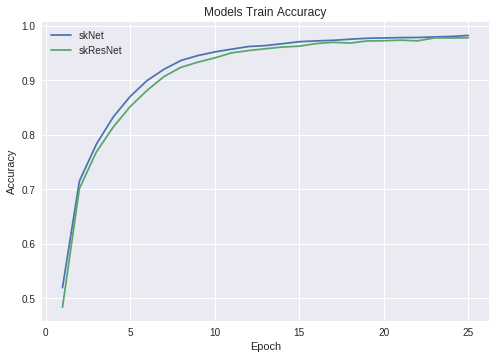

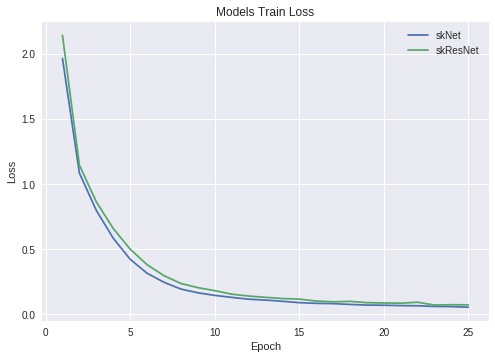

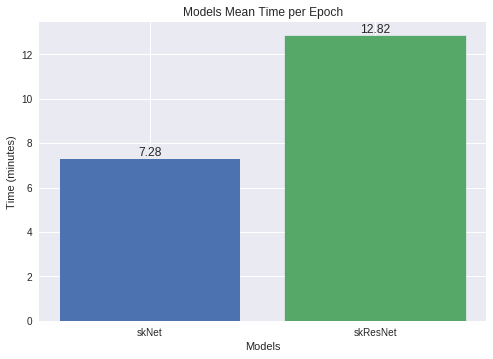

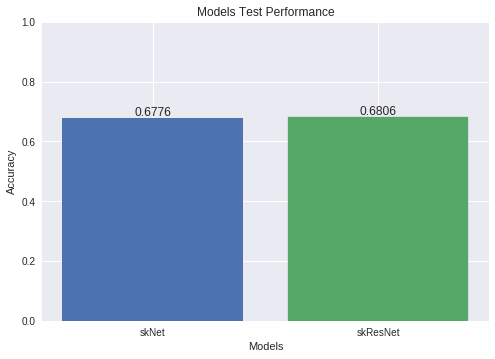

In [0]:
# Train Accuracy
plt.figure()
plt.plot(range(1, len(skNet_train_acc) + 1), skNet_train_acc)
plt.plot(range(1, len(skResNet_train_acc) + 1), skResNet_train_acc)
plt.title('Models Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['skNet', 'skResNet'])
plt.show()

# Train Loss
plt.figure()
plt.plot(range(1, len(skNet_train_loss) + 1), skNet_train_loss)
plt.plot(range(1, len(skResNet_train_loss) + 1), skResNet_train_loss)
plt.title('Models Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['skNet', 'skResNet'])
plt.show()

# Mean Time per Epoch
c = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
plt.figure()
bar = plt.bar(['skNet', 'skResNet'], [float("{0:.2f}".format(np.mean(skNet_epoch_time) / 60)), float("{0:.2f}".format(np.mean(skResNet_epoch_time) / 60))])
bar[1].set_color(c)
plt.title('Models Mean Time per Epoch')
plt.xlabel('Models')
plt.ylabel('Time (minutes)')
for rect in bar:
  height = rect.get_height()
  plt.text(rect.get_x() + rect.get_width()/2.0, height, height, ha='center', va='bottom')
plt.show()

# Test Accuracy
plt.figure()
bar = plt.bar(['skNet', 'skResNet'], [float("{0:.4f}".format(skNet_test_acc)), float("{0:.4f}".format(skResNet_test_acc))])
bar[1].set_color(c)
plt.ylim((0, 1))
plt.title('Models Test Performance')
plt.xlabel('Models')
plt.ylabel('Accuracy')
for rect in bar:
  height = rect.get_height()
  plt.text(rect.get_x() + rect.get_width()/2.0, height, height, ha='center', va='bottom')
plt.show()

### 6. Búsqueda por Similitud




In [0]:
# Models download
os.makedirs('./Prueba')
download_files_from_drive('./Prueba', drive_save_path + '/skNet')
download_files_from_drive('./Prueba', drive_save_path + '/skResNet')

Files downloaded sucessfully from drive!
Files downloaded sucessfully from drive!


In [0]:
# General functions for this section
def L2_norm(char_vec_1,char_vec_2):
  if len(char_vec_1)==len(char_vec_2):
    l1=np.asarray(char_vec_1)
    l2=np.asarray(char_vec_2)
    return np.linalg.norm(l1-l2)
  else:
    return None     

def search_and_sort(char_vec,database_vec,distance_method=L2_norm,show_time=False):
  distance_vec=[]
  t_start_comparasion=time.clock()
  for element in database_vec:
    distance=distance_method(char_vec,element[0])
    distance_vec.append((element[0],element[1],element[2],distance))
  dt_comparasion=time.clock()-t_start_comparasion
  t_start_sorting=time.clock()
  distance_vec.sort(key=lambda x:x[3])
  dt_sort=time.clock()-t_start_sorting
  if show_time:
    print('   Elapsed Time on Comparasion {:.1f}'.format(dt_comparasion))
    print('   Elapsed Time on Sorting     {:.1f}'.format(dt_sort))
  return distance_vec

def accuracy_of_search(correct_label,result_vector):
  correct=0
  for r in result_vector:
    if correct_label==r[1]:
      correct+=1
  return correct/len(result_vector)

def aP(correct_label,result_vector):
  relevant_acc=0
  relevant=0
  for i in range(len(result_vector)):
    if correct_label==result_vector[i][1]:#count only relevants
      relevant_acc+=accuracy_of_search(correct_label,result_vector[0:i+1])
      relevant+=1
  if relevant==0:
    return 0
  return relevant_acc/relevant

#### 6.1. Characteristics Extraccion Using skNet Model

In [0]:
# Default graph reset
tf.reset_default_graph()

# Dataset
with tf.name_scope('Dataset') as scope:
  # Filename placeholder
  filenames = tf.placeholder(tf.string, shape=[None])
  # TFRecordDataset construction
  dataset = tf.data.TFRecordDataset(filenames)
  # Parse the tfrecord files into tensors
  dataset = dataset.map(_parse_function)
  # Dataset batching
  dataset = dataset.batch(1)
  # Dataset iterator
  iterator = dataset.make_initializable_iterator()
  # Dataset batch extraction [batch_data, batch_label]
  next_element = iterator.get_next()

# Model Contruction
logits = skNet(next_element[0])

# Extractor 
with tf.name_scope('Extractor'):  
  label_extractor = tf.to_int64(next_element[1])
  

# Model restoring parameters
with tf.Session() as sess:
  saver = tf.train.import_meta_graph('./Prueba/skNet.meta')
  saver.restore(sess, './Prueba/skNet')
  print('skNet restored sucessfuly!')
  sess.close()


# Characteristics vector
char_vec_extractor = tf.get_default_graph().get_tensor_by_name('skNet/fc1/Relu:0')

INFO:tensorflow:Restoring parameters from ./Prueba/skNet
skNet restored sucessfuly!


In [0]:
db_vec = []
epoch_to_show=1000

# Session to extract Characteristics Vectors from the database and save it
with tf.Session() as sess:
  t=time.clock()
  actual_data=0
  print('Extracting Characteristics Vectors from the database')
  init_op = tf.global_variables_initializer()
  sess.run(init_op)
  sess.run(iterator.initializer, feed_dict={filenames: testing_filenames})
  while True:
    try:
      actual_data+=1
      if actual_data%epoch_to_show==1:
        t_start=time.clock()
        
      vec,label = sess.run([char_vec_extractor,label_extractor])
      db_vec.append((vec[0],label,testing_filenames[actual_data-1]))
      #Char Vec , Label , filename
      
      if actual_data%epoch_to_show==0:
        print ('{} Elements has been processed | Elpased Time : {:.1f} seconds'.format(actual_data,time.clock()-t_start))
    except tf.errors.OutOfRangeError:
      break
print("Extraction of Characteristics Vectors has been computed Succesfully!")
print('Total Elapsed Time : {:.1f} minutes'.format((time.clock()-t)/60.0))

Extracting Characteristics Vectors from the database
1000 Elements has been processed | Elpased Time : 8.5 seconds
2000 Elements has been processed | Elpased Time : 7.5 seconds
3000 Elements has been processed | Elpased Time : 7.1 seconds
4000 Elements has been processed | Elpased Time : 6.5 seconds
5000 Elements has been processed | Elpased Time : 5.9 seconds
Extraction of Characteristics Vectors has been computed Succesfully!
Total Elapsed Time : 0.6 minutes


In [0]:
#Calculation of maP over the testing database
actual_example=1
epoch_to_show=1000
n_relevants=50

maP_per_class=[0]*n_classes
maP_per_class=np.asarray(maP_per_class)

print('Calculating maP over the testing database')
t=time.clock()
for e in db_vec:
  if actual_example%epoch_to_show==1:
    t_start=time.clock()

  result_search=search_and_sort(e[0],db_vec)[1:n_relevants+1] #one leave out
  aP_example=aP(e[1],result_search)
  maP_per_class[e[1]]=maP_per_class[e[1]]+aP_example #sum of ap per class

  if actual_example%epoch_to_show==0:
    print ('{} Elements has been processed | Elpased Time : {:.1f} seconds'.format(actual_example,time.clock()-t_start))

  actual_example+=1

maP_per_class=maP_per_class/test_data_size
maP_general_skNet=np.mean(maP_per_class)

print('maP over testing database : {:.4f}%'.format(maP_general_skNet*100.0))
print('Total Elapsed Time : {:.1f} minutes'.format((time.clock()-t)/60.0))

Calculating maP over the testing database
1000 Elements has been processed | Elpased Time : 48.7 seconds
2000 Elements has been processed | Elpased Time : 49.0 seconds
3000 Elements has been processed | Elpased Time : 48.2 seconds
4000 Elements has been processed | Elpased Time : 47.7 seconds
5000 Elements has been processed | Elpased Time : 47.5 seconds
maP over testing database : 0.9400%
Total Elapsed Time : 4.0 minutes


In [0]:
#Show random examples of aP
print('Show random examples of aP')
print()
n_examples=5
n_relevants=10
examples = random.sample(db_vec, n_examples)

t=time.clock()
for e in examples:
  print('Example : '+e[2])
  print()
  t_start_example=time.clock()
  
  result_search=search_and_sort(e[0],db_vec)[1:n_relevants+1]
  acc_example=accuracy_of_search(e[1],result_search)
  aP_example=aP(e[1],result_search)
  
  print('Acc on {} relevants of search: {:.2f}%'.format(n_relevants,acc_example*100))
  print(' aP on {} relevants of search: {:.2f}%'.format(n_relevants,aP_example*100))
  
  print('Elapsed Time {:.1f}'.format(time.clock()-t_start_example))
  print('---------------------------------')
  
print('Total Elapsed Time {:.1f}'.format(time.clock()-t))  

Show random examples of aP

Example : ./CC6204/Tarea_2/quickdraw_dataset/tfrecords/test/axe_1004.tfrecords

Acc on 10 relevants of search: 10.00%
 aP on 10 relevants of search: 100.00%
Elapsed Time 0.0
---------------------------------
Example : ./CC6204/Tarea_2/quickdraw_dataset/tfrecords/test/dresser_1035.tfrecords

Acc on 10 relevants of search: 40.00%
 aP on 10 relevants of search: 62.50%
Elapsed Time 0.1
---------------------------------
Example : ./CC6204/Tarea_2/quickdraw_dataset/tfrecords/test/cruise ship_1037.tfrecords

Acc on 10 relevants of search: 0.00%
 aP on 10 relevants of search: 0.00%
Elapsed Time 0.1
---------------------------------
Example : ./CC6204/Tarea_2/quickdraw_dataset/tfrecords/test/beach_1001.tfrecords

Acc on 10 relevants of search: 0.00%
 aP on 10 relevants of search: 0.00%
Elapsed Time 0.1
---------------------------------
Example : ./CC6204/Tarea_2/quickdraw_dataset/tfrecords/test/bicycle_1004.tfrecords

Acc on 10 relevants of search: 10.00%
 aP on 10 r

#### 6.2. Characteristics Extraccion Using skResNet Model

In [0]:
# Default graph reset
tf.reset_default_graph()

# Dataset
with tf.name_scope('Dataset') as scope:
  # Filename placeholder
  filenames = tf.placeholder(tf.string, shape=[None])
  # TFRecordDataset construction
  dataset = tf.data.TFRecordDataset(filenames)
  # Parse the tfrecord files into tensors
  dataset = dataset.map(_parse_function)
  # Dataset batching
  dataset = dataset.batch(1)
  # Dataset iterator
  iterator = dataset.make_initializable_iterator()
  # Dataset batch extraction [batch_data, batch_label]
  next_element = iterator.get_next()

# Model Contruction
logits = skResNet(next_element[0])

# Extractor 
with tf.name_scope('Extractor'):  
  label_extractor = tf.to_int64(next_element[1])

# Model restoring parameters
with tf.Session() as sess:
  saver = tf.train.import_meta_graph('./Prueba/skResNet.meta')
  saver.restore(sess, './Prueba/skResNet')
  print('skResNet restored sucessfuly!')
  sess.close()

# Characteristics vector
char_vec_extractor = tf.get_default_graph().get_tensor_by_name('skResNet/fc1/Relu:0')

INFO:tensorflow:Restoring parameters from ./Prueba/skResNet
skResNet restored sucessfuly!


In [0]:
db_vec = []
epoch_to_show = 1000

# Session to extract Characteristics Vectors from the database and save it
with tf.Session() as sess:
  t=time.clock()
  actual_data=0
  print('Extracting Characteristics Vectors from the database')
  init_op = tf.global_variables_initializer()
  sess.run(init_op)
  sess.run(iterator.initializer, feed_dict={filenames: testing_filenames})
  while True:
    try:
      actual_data+=1
      if actual_data%epoch_to_show==1:
        t_start=time.clock()
        
      vec,label = sess.run([char_vec_extractor,label_extractor])
      db_vec.append((vec[0],label,testing_filenames[actual_data-1]))
      #Char Vec , Label , filename
      
      if actual_data%epoch_to_show==0:
        print ('{} Elements has been processed | Elpased Time : {:.1f} seconds'.format(actual_data,time.clock()-t_start))
    except tf.errors.OutOfRangeError:
      break
print("Extraction of Characteristics Vectors has been computed Succesfully!")
print('Total Elapsed Time : {:.1f} minutes'.format((time.clock()-t)/60.0))

Extracting Characteristics Vectors from the database
1000 Elements has been processed | Elpased Time : 12.7 seconds
2000 Elements has been processed | Elpased Time : 12.3 seconds
3000 Elements has been processed | Elpased Time : 12.3 seconds
4000 Elements has been processed | Elpased Time : 12.3 seconds
5000 Elements has been processed | Elpased Time : 12.3 seconds
Extraction of Characteristics Vectors has been computed Succesfully!
Total Elapsed Time : 1.1 minutes


In [0]:
#Calculation of maP over the testing database
actual_example=1
epoch_to_show=1000
n_relevants=50
maP_per_class=[0]*n_classes
maP_per_class=np.asarray(maP_per_class)


print('Calculating maP over the testing database')
t=time.clock()
for e in db_vec:
  if actual_example%epoch_to_show==1:
    t_start=time.clock()

  result_search=search_and_sort(e[0],db_vec)[1:n_relevants+1] #one leave out
  aP_example=aP(e[1],result_search)
  maP_per_class[e[1]]=maP_per_class[e[1]]+aP_example  #sum of ap per class

  if actual_example%epoch_to_show==0:
    print ('{} Elements has been processed | Elpased Time : {:.1f} seconds'.format(actual_example,time.clock()-t_start))

  actual_example+=1

maP_per_class=maP_per_class/test_data_size
maP_general_skResNet=np.mean(maP_per_class)
print('maP over testing database : {:.4f}%'.format(maP_general_skResNet*100.0))
print('Total Elapsed Time : {:.1f} minutes'.format((time.clock()-t)/60.0))

Calculating maP over the testing database
1000 Elements has been processed | Elpased Time : 47.7 seconds
2000 Elements has been processed | Elpased Time : 47.7 seconds
3000 Elements has been processed | Elpased Time : 47.7 seconds
4000 Elements has been processed | Elpased Time : 47.7 seconds
5000 Elements has been processed | Elpased Time : 47.8 seconds
maP over testing database : 1.3000%
Total Elapsed Time : 4.0 minutes


In [0]:
#Show random examples of aP
print('Show random examples of aP')
print()
n_examples=5
n_relevants=10
examples = random.sample(db_vec, n_examples)

t=time.clock()
for e in examples:
  print('Example : '+e[2])
  print()
  t_start_example=time.clock()
  
  result_search=search_and_sort(e[0],db_vec)[1:n_relevants+1]
  acc_example=accuracy_of_search(e[1],result_search)
  aP_example=aP(e[1],result_search)
  
  print('Acc on {} relevants of search: {:.2f}%'.format(n_relevants,acc_example*100))
  print(' aP on {} relevants of search: {:.2f}%'.format(n_relevants,aP_example*100))
  
  print('Elapsed Time {:.1f}'.format(time.clock()-t_start_example))
  print('---------------------------------')
  
print('Total Elapsed Time {:.1f}'.format(time.clock()-t))  

Show random examples of aP

Example : ./CC6204/Tarea_2/quickdraw_dataset/tfrecords/test/canoe_1022.tfrecords

Acc on 10 relevants of search: 0.00%
 aP on 10 relevants of search: 0.00%
Elapsed Time 0.1
---------------------------------
Example : ./CC6204/Tarea_2/quickdraw_dataset/tfrecords/test/backpack_1008.tfrecords

Acc on 10 relevants of search: 0.00%
 aP on 10 relevants of search: 0.00%
Elapsed Time 0.1
---------------------------------
Example : ./CC6204/Tarea_2/quickdraw_dataset/tfrecords/test/diving board_1045.tfrecords

Acc on 10 relevants of search: 0.00%
 aP on 10 relevants of search: 0.00%
Elapsed Time 0.1
---------------------------------
Example : ./CC6204/Tarea_2/quickdraw_dataset/tfrecords/test/apple_1044.tfrecords

Acc on 10 relevants of search: 30.00%
 aP on 10 relevants of search: 72.22%
Elapsed Time 0.1
---------------------------------
Example : ./CC6204/Tarea_2/quickdraw_dataset/tfrecords/test/blueberry_1045.tfrecords

Acc on 10 relevants of search: 20.00%
 aP on 1

#### 6.3. Models mAP

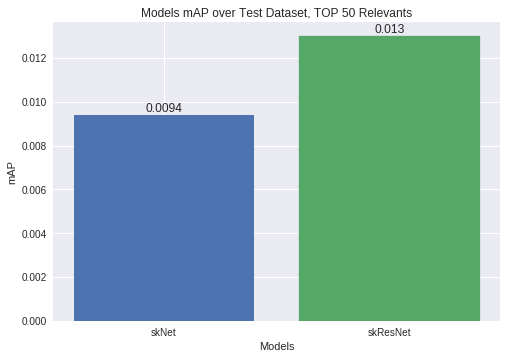

In [0]:
# Models mAP over Test Dataset, TOP 50 Relevants 
c = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
plt.figure()
bar = plt.bar(['skNet', 'skResNet'], [float("{0:.4f}".format(maP_general_skResNet)), float("{0:.4f}".format(maP_general_skNet))])
bar[1].set_color(c)
plt.title('Models mAP over Test Dataset, TOP 50 Relevants')
plt.xlabel('Models')
plt.ylabel('mAP')
for rect in bar:
  height = rect.get_height()
  plt.text(rect.get_x() + rect.get_width()/2.0, height, height, ha='center', va='bottom')
plt.show()